In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import json, copy
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from config import *
import matplotlib as mpl

In [2]:
package_versions = {}
with open("packages.json") as f:
    pkgs = json.load(f)
costs={}
for package_name in pkgs.keys():
    if package_name not in package_versions:
        package_versions[package_name] = []
    for package_version in pkgs[package_name]["versions"]:
        package_versions[package_name].append(package_version)
        costs[f'{package_name}=={package_version}']= pkgs[package_name]["versions"][package_version]["cost"]

version_to_label = {    
    "v0": "single-package+Uniform Weight",
    "v1": "single-package+Time-based Weight",
    "v2": "multi-package+Uniform Weight",
    "v3": "multi-package+Time-based Weight"
}

costs

{'cython==3.0.2': {'i-ms': 3.7071704864501953,
  'i-mb': 0.2710599899291992,
  'ms': 3.6401748657226562,
  'mb': 0.2710599899291992},
 'numpy==1.26.0': {'i-ms': 45.94540596008301,
  'i-mb': 3.852707862854004,
  'ms': 45.670509338378906,
  'mb': 3.8537302017211914},
 'numpy==1.25.2': {'i-ms': 46.247005462646484,
  'i-mb': 3.867854118347168,
  'ms': 47.393798828125,
  'mb': 3.867373466491699},
 'numpy==1.24.4': {'i-ms': 39.700984954833984,
  'i-mb': 3.5766916275024414,
  'ms': 40.15088081359863,
  'mb': 3.5767059326171875},
 'packaging==21.3': {'i-ms': 0.2391338348388672,
  'i-mb': 0,
  'ms': 0.23055076599121094,
  'mb': 0},
 'packaging==23.1': {'i-ms': 0.13756752014160156,
  'i-mb': 0,
  'ms': 0.1361370086669922,
  'mb': 0},
 'scipy==1.11.2': {'i-ms': 25.87151527404785,
  'i-mb': 0.3653545379638672,
  'ms': 5.30695915222168,
  'mb': 0.3655080795288086},
 'certifi==2023.7.22': {'i-ms': 5.855798721313477,
  'i-mb': 0.20975399017333984,
  'ms': 5.777597427368164,
  'mb': 0.2097539901733398

In [3]:
node_color = "#1E90FF"
font_color = "#2F4F4F"
import math, re
import hashlib
import matplotlib.colors as mcolors
import colorsys

label_dict = {
    'pandas': 'skyblue',
    'matplotlib': 'mpl',
    'sqlalchemy': 'sqla',
    'numpy': 'np',
    'scikit-learn': 'skl',
    'nbconvert': 'nb',
    'jupyter': 'jp'
}

color_dict = {
    'pandas': 'darkblue',
    'matplotlib': 'green',
    'sqlalchemy': 'purple',
    'numpy': 'brown',
    'scikit-learn': 'lime',
    'nbconvert': 'indigo',
    'jupyter': 'orange'
}

font_dict = {
    'pandas': 'white',
    'matplotlib': 'white',
    'sqlalchemy': 'white',
    'numpy': 'white',
    'scikit-learn': 'white',
    'nbconvert': 'white',
    'jupyter': 'black'
}

def add_depth(node, parent=None, depth=0):
    node["depth_to_root"] = depth
    max_child_depth = 0 
    for child in node.get('children', []): 
        child_depth = add_depth(child, node, depth + 1)
        max_child_depth = max(max_child_depth, child_depth) 
    node["depth_to_leaf"] = max_child_depth  
    return max_child_depth + 1

def sort_layer_by_subtree_depth(layer):
    sorted_nodes = sorted(layer, key=lambda node: node["subtree_depth"])
    mid = len(sorted_nodes) // 2
    first_half = sorted_nodes[:mid]
    second_half = sorted_nodes[mid:]
    first_half.reverse()
    second_half.reverse()
    return first_half + second_half

def sort_by_parent(layer):
    sorted_nodes = sorted(layer, key=lambda node: node["parent"]["coord"][1] if node["parent"] is not None else 0.5 * ax.get_ylim()[1])
    return sorted_nodes

def version_to_tuple(version):
    version_numbers = re.findall(r'\d+', version)
    return tuple(map(int, version_numbers))

def version_difference(version, max_version):
    v = version_to_tuple(version)
    max_v = version_to_tuple(max_version)
    length_diff = len(max_v) - len(v)
    if length_diff > 0:
        v += (0,) * length_diff
    elif length_diff < 0:
        max_v += (0,) * -length_diff
    diff = sum(abs(a - b) for a, b in zip(v, max_v))
    return diff

def get_color(package_name, version):
    if package_name not in label_dict.keys():
        return 'lightblue'
    
    base_color_hex = color_dict.get(package_name)
    base_color_rgb = mcolors.hex2color(base_color_hex)
    base_color_hsv = colorsys.rgb_to_hsv(*base_color_rgb)

    max_version = max(package_versions[package_name], key=version_to_tuple)
    version_diff = version_difference(version, max_version)

    version_offset = version_diff * 0.1  
    new_saturation = min(max(base_color_hsv[1] - version_offset, 0.0), 1.0)  

    adjusted_color_hsv = (base_color_hsv[0], new_saturation, base_color_hsv[2])
    adjusted_color_rgb = colorsys.hsv_to_rgb(*adjusted_color_hsv)

    return adjusted_color_rgb

def calculate_luminance(color_hex):
    r, g, b = mcolors.hex2color(mcolors.CSS4_COLORS[color_hex])
    return 0.299 * r + 0.587 * g + 0.114 * b
def get_font_color_from_dict(pkg_name):
    color_name = color_dict.get(package_name, 'lightblue')
    if pkg_name in font_dict:
        return font_dict[pkg_name]
    else:
        return 'black' if calculate_luminance(color_name) > 0.5 else 'white'

In [4]:
# tree is in dict format
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as font_manager

font_props = font_manager.FontProperties(family='sans-serif', 
                                         style='normal', 
                                         weight=1000, 
                                         size=16)


def draw_tree(tree, ax=None, heat_color=False, generation_max=9999999, legend = True):
    package_versions_seen = {}
    flip=1
    if type(tree) == str:
        with open(tree) as f:
            tree = json.load(f)
    else:
        tree = copy.deepcopy(tree)
    add_depth(tree)
        
    size = (15,10)
    if ax == None:
        _, ax = plt.subplots(1, figsize=size) # note we must use plt.subplots, not plt.subplot
    else:
        ax.cla()
    ax.set_xlim((0, size[0]))
    ax.set_ylim((-0.1, size[1]))
    plt.axis('off')

    # for aesthetics, we want children with the most nodes in the middle of the child list
    # (so that the middle goes deep and the tree is more symmetric)
    def sort_children(node):
        node["descendents"] = 0
        for child in node["children"]:
            child["parent"] = node
            sort_children(child)
            node["descendents"] += child["descendents"] + 1
        children = sorted(node["children"], key=lambda node: node["descendents"])
        node["children"] = children[0::2] + children[1::2][::-1]
        
    sort_children(tree)
    tree["parent"]=None
    node_count = tree["descendents"]  + 1
    layers = []
    def layer_tree(node, layernum):
        if len(layers) <= layernum:
            layers.append([])
        layers[layernum].append(node)
        for child in node["children"]:
            layer_tree(child, layernum+1)            
    layer_tree(tree, 0)

    total_count = sum(node.get('test_count', 0) for layer in layers for node in layer)
    all_counts = [node.get('test_count', 0) for layer in layers for node in layer if node != tree] 
    min_count, max_count = min(all_counts), max(all_counts)
    min_ratio = min_count / total_count
    max_ratio = 0.15
    
    max_area =  max(sum(costs[p]["ms"] for p in node["packages"]) for layer in layers for node in layer)
    
    def draw_node(coord=None, label='', area=1, count=0, pkg_cnt=None):
        if coord == None:
            coord = ()
        min_radius = 0.06
        max_radius = 0.6
        radius = max((area**0.5)*0.025, min_radius)
        radius = min(radius, max_radius)
        # heat tree
        if heat_color and max_count > min_count: 
            color_value = (count/total_count - min_ratio) / (max_ratio - min_ratio)
            node_color = plt.cm.Reds(color_value)  
        else:
            lighter_blue = (0.5, 0.7, 1.0)
            node_color = lighter_blue
        if label:
            package_name, version = label.split("==")
            if package_name in label_dict.keys(): 
                if package_name not in package_versions_seen.keys():
                    package_versions_seen[package_name]=set()
                package_versions_seen[package_name].add(version)
            node_color = get_color(package_name, version)
        ax.add_artist(plt.Circle(coord, radius, facecolor=node_color, linewidth=0, edgecolor=node_color, zorder=radius))

        if pkg_cnt>5:
            text = plt.Text(*coord, pkg_cnt, 
                            color=get_font_color_from_dict(package_name), 
                            zorder=radius+0.01,
                            verticalalignment='center', 
                            horizontalalignment='center',
                            fontproperties=font_props)

            ax.add_artist(text)
        name = label.split("==")[0]    
        if False and label and name in label_dict.keys():
            name = label_dict[name]
            version = label.split("==")[1]
            tex_label = f'{name} {{\\small {version}}}'
            text_y_offset = -0.1
            if area <50: 
                ax.add_artist(plt.Text(coord[0], coord[1] + text_y_offset, tex_label, color=font_color, size=16, zorder=radius+0.01,
                                       verticalalignment='top', horizontalalignment='center'))
            else:
                ax.add_artist(plt.Text(*coord, tex_label, color=font_color, size=16, zorder=radius+0.01,
                                       verticalalignment='center', horizontalalignment='center'))

    def draw_edge(coord1, coord2, label='', **style):
        ax.add_artist(plt.Polygon([coord1, coord2], zorder=-1, **style))

    # draw nodes
    for lnum, layer in enumerate(layers):
        for nnum, node in enumerate(layer):
            # decay y
            org_x = (lnum+0.5)/(len(layers)+1) * ax.get_xlim()[1]
            org_y = (nnum+0.5)/len(layer) * ax.get_ylim()[1]
            
            offset_from_center = org_y - 5
            if len(layer)<3:
                decay = 0.3
            elif len (layer)<5:
                decay = 0.5
            elif len(layer)<7:
                decay = 0.7
            else:
                decay = 1.0 
            org_y = (offset_from_center * decay) + 5
            node["org_coord"] = (org_x, org_y)
            node['flip'] = 1
            x = org_x
            y = org_y
           
            if node["parent"] is not None and org_y==node["parent"]['org_coord'][1]:
                node['flip']*=node["parent"]['flip']*(-1)
                y = org_y+node['flip']*0.2
            # # shorten edge
            # if node["parent"]!=None and math.isclose(node["parent"]["coord"][1], 0.5 * ax.get_ylim()[1], rel_tol=0.2)and len(layer)>1 and lnum>4:
            #     if len(node["parent"]["children"])==1:
            #         y = 0.5 * ax.get_ylim()[1]
            #         y += flip*0.2
            #         flip*=(-1)
            #     else:
            #         y = (y+node["parent"]["coord"][1])/2
            # elif len(layers[lnum-1])==1 and len(layer)==1:
            #     y += flip*0.2
            #     flip*=(-1)
            # decay_factor = 0.99
            # if lnum > 3:
            #     x *= decay_factor ** (lnum - 3)
            
            node["coord"] = (x, y)
            
            assert len(node["direct"]) <= 1

            label = ''
            if len(node["direct"]) == 1:
                library_name = node["direct"][0].split("==")[0]
                label = library_name + "==" + node["direct"][0].split("==")[1]
                #label = ""
        
            area = sum(costs[p]["ms"] for p in node["packages"])
            if node["split_generation"] < generation_max:
                c = node["test_count"]
                pkg_cnt = len(node["packages"])
                draw_node(node["coord"], label=label, area=area, count=c, pkg_cnt=pkg_cnt)

    # draw edges
    def recursive_edges(node):
        for child in node["children"]:
            linestyle = (0,())
            g = child["split_generation"]
            area = sum(costs[p]["ms"] for p in node["packages"])
            normalized_area = area / max_area if max_area > 0 else 0
            width = 1 + 4 * ((node_count-g)/node_count)* normalized_area
            if child["split_generation"] < generation_max:
                draw_edge(node["coord"], child["coord"], linewidth=width, color="black")
                recursive_edges(child)

    recursive_edges(tree)

    
    if heat_color:
        norm = mpl.colors.Normalize(vmin=0, vmax=max_ratio)
        cmap = plt.cm.Reds
        cax = plt.axes([0.90, 0.2, 0.02, 0.3])
        plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    
    patches = []
    labels = []
    for package_name, versions in package_versions_seen.items():
        for version in versions:
            color_rgb = get_color(package_name,version)
            patch = mpatches.Patch(color=color_rgb, label=f'{package_name} ({version})')
            patches.append(patch)
            labels.append(f'{package_name} ({version})')
            
    patch = mpatches.Patch(color='lightblue', label='other')
    patches.append(patch)
    labels.append('other')

    if legend:
        font_prop = FontProperties(family='Helvetica', size=21, weight='black')
        legend = ax.legend(handles=patches, labels=labels, loc='upper right', title='Packages and Versions', 
                           title_fontsize=20, prop=font_prop,
                          handlelength=2, handletextpad=0.5,labelspacing=0.3)
        legend.get_title().set_weight('black')
        legend.get_title().set_fontname('Arial')
        ax.add_artist(legend)
    
    return ax, package_versions_seen

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
os.makedirs(os.path.join("pics", "0"), exist_ok=True)


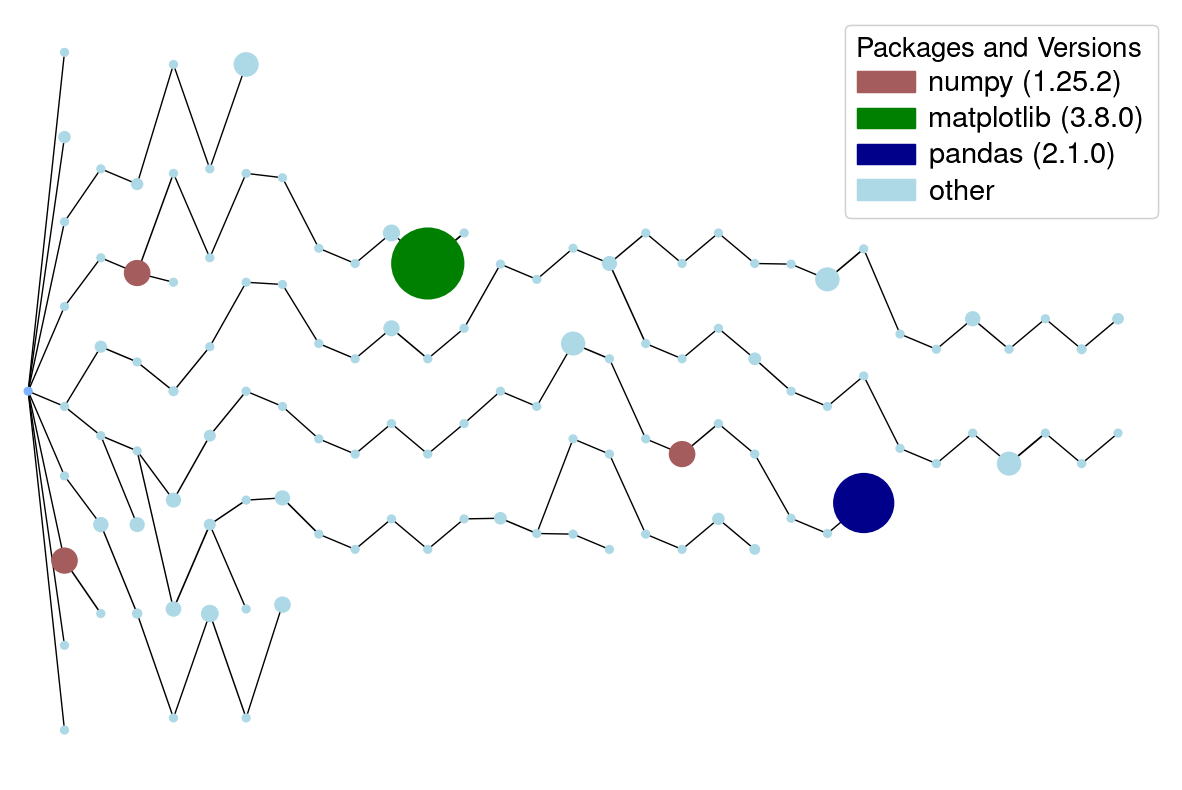

In [37]:
# the tree is different from the one in the paper
tree_name="tree-v0.node-120"
ax, _ = draw_tree(os.path.join("trials", "tree_gen", "0", tree_name+".json"),heat_color=False)

fig1 = ax.get_figure()
fig1.savefig(os.path.join("pics", "0" , "baseline-120.pdf"), bbox_inches='tight')

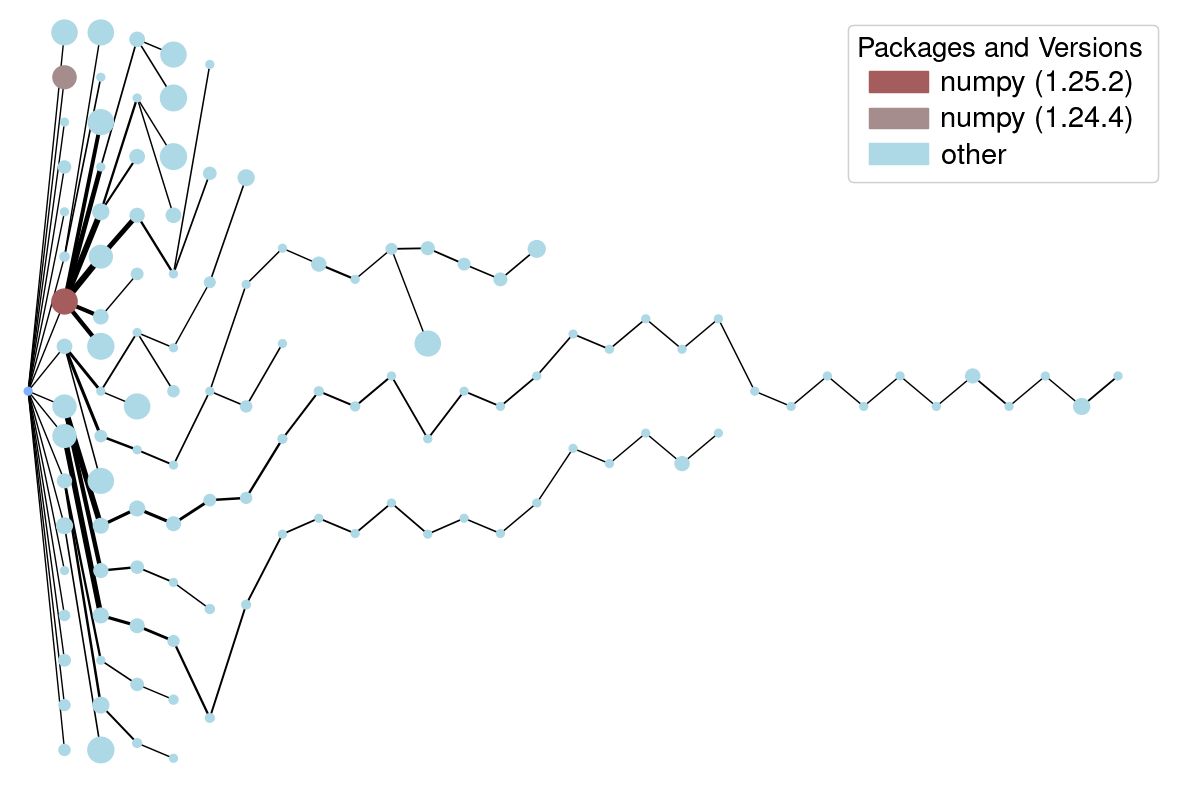

In [6]:
tree_name="tree-v1.node-120"
ax,_ = draw_tree(os.path.join( "trials", "tree_gen", "0", tree_name+".json"),heat_color=False)

fig2 = ax.get_figure()
fig2.savefig(os.path.join("pics", "0" , "weight-120.pdf"), bbox_inches='tight')

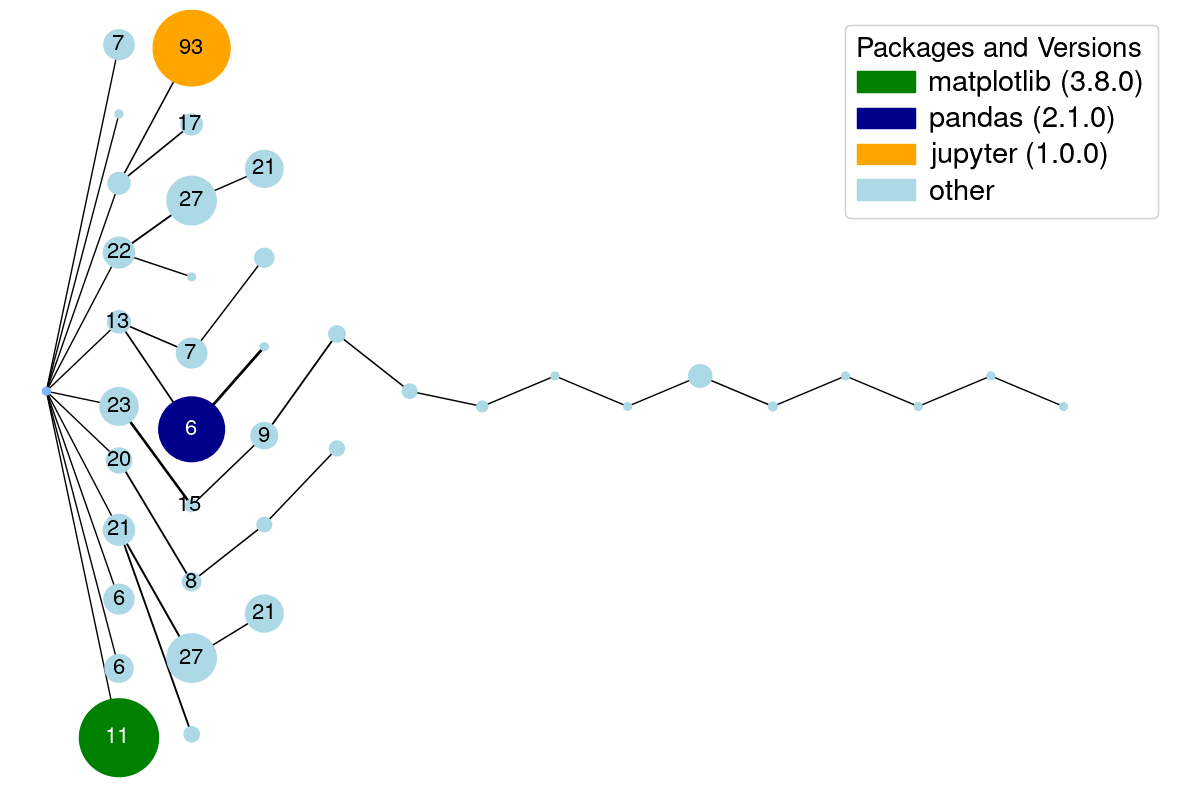

In [7]:
# fig 9
tree_name="tree-v2.node-40"
ax,_ = draw_tree(os.path.join( "trials", "tree_gen", "0", tree_name+".json"),heat_color=False)

fig3 = ax.get_figure()
fig3.savefig(os.path.join("pics", "0" , "multipkg-40.pdf"), bbox_inches='tight')

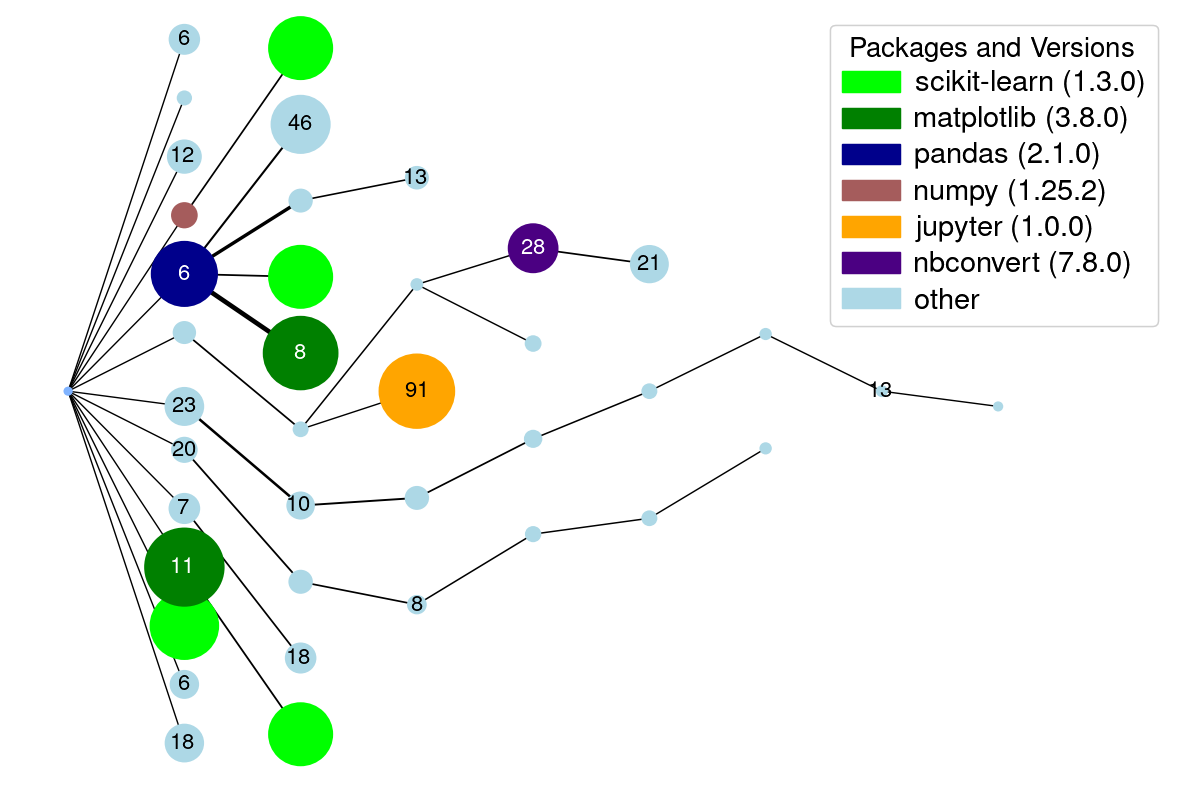

In [8]:
# fig 10
tree_name="tree-v3.node-40"
ax,_ = draw_tree(os.path.join( "trials", "tree_gen", "0", tree_name+".json"),heat_color=False)

fig4 = ax.get_figure()
fig4.savefig(os.path.join("pics", "0" , "multipkg_weight-40.pdf"), bbox_inches='tight')

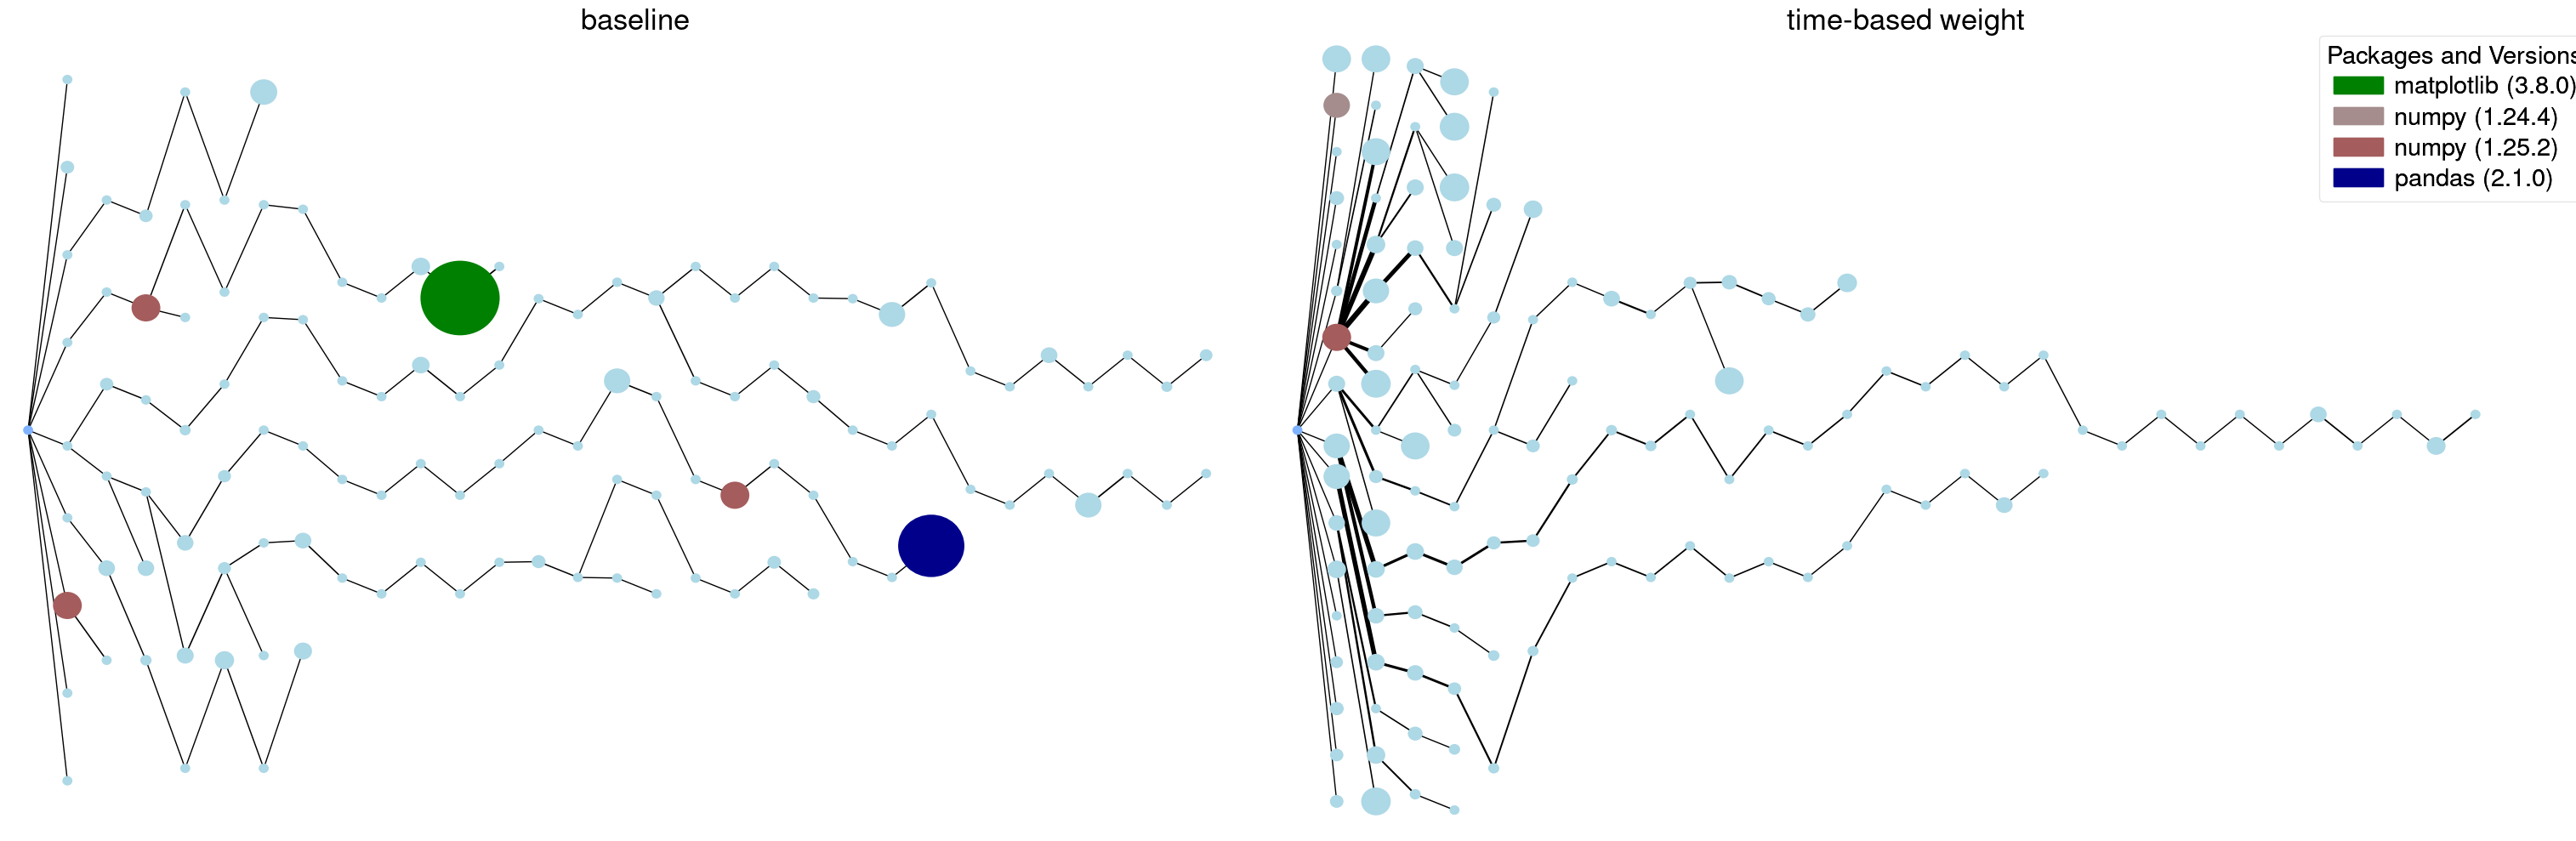

In [45]:
def merge_dicts(dict1, dict2):
    merged_dict = {}
    all_keys = set(dict1.keys()).union(set(dict2.keys()))

    for key in all_keys:
        versions_in_dict1 = dict1.get(key, set())
        versions_in_dict2 = dict2.get(key, set())
        merged_dict[key] = versions_in_dict1.union(versions_in_dict2)
    return merged_dict

trees = [
os.path.join( "trials", "tree_gen", "0", "tree-v0.node-120.json"),
os.path.join( "trials", "tree_gen", "0", "tree-v1.node-120.json"),
]

titles = [
    "baseline",
    "time-based weight",
    "multi-package",
    "multi-package, time-based weight"
]
pkgs = {}
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
for i, tree_file in enumerate(trees):
    row_index = i // 2
    col_index = i % 2
    ax = axs[col_index]#ax = axs[row_index, col_index]

    ax = axs[i]
    _, sub_packages = draw_tree(tree_file, ax=ax, heat_color=False, legend=False)
    pkgs = merge_dicts(pkgs, sub_packages)
    ax.set_axis_off()
    if i<2:
        ax.set_title(titles[i], fontsize=25)
    
    ax.set_ylabel("dads") 

patches = []
labels = []
for package_name, versions in pkgs.items():
    for version in versions:
        color_hex = color_dict.get(package_name)
        color_rgb = get_color(package_name,version)
        patch = mpatches.Patch(color=color_rgb, label=f'{package_name} ({version})')
        patches.append(patch)
        labels.append(f'{package_name} ({version})')
patch = mpatches.Patch(color='lightblue', label='other')
patches.append(patch)

font_prop = FontProperties(family='Helvetica', size=21, weight='black')
legend = fig.legend(handles=patches, labels=labels, loc=(0.9, 0.76), title='Packages and Versions', 
                   title_fontsize=21, prop=font_prop,
                   handlelength=2, handletextpad=0.5, labelspacing=0.3)
frame = legend.get_frame()
frame.set_alpha(0.3)
legend.get_title().set_weight('black')
legend.get_title().set_fontname('Arial')
ax.add_artist(legend)

plt.tight_layout()

plt.savefig("v0_v1_120-node.pdf", format='pdf')
plt.show()

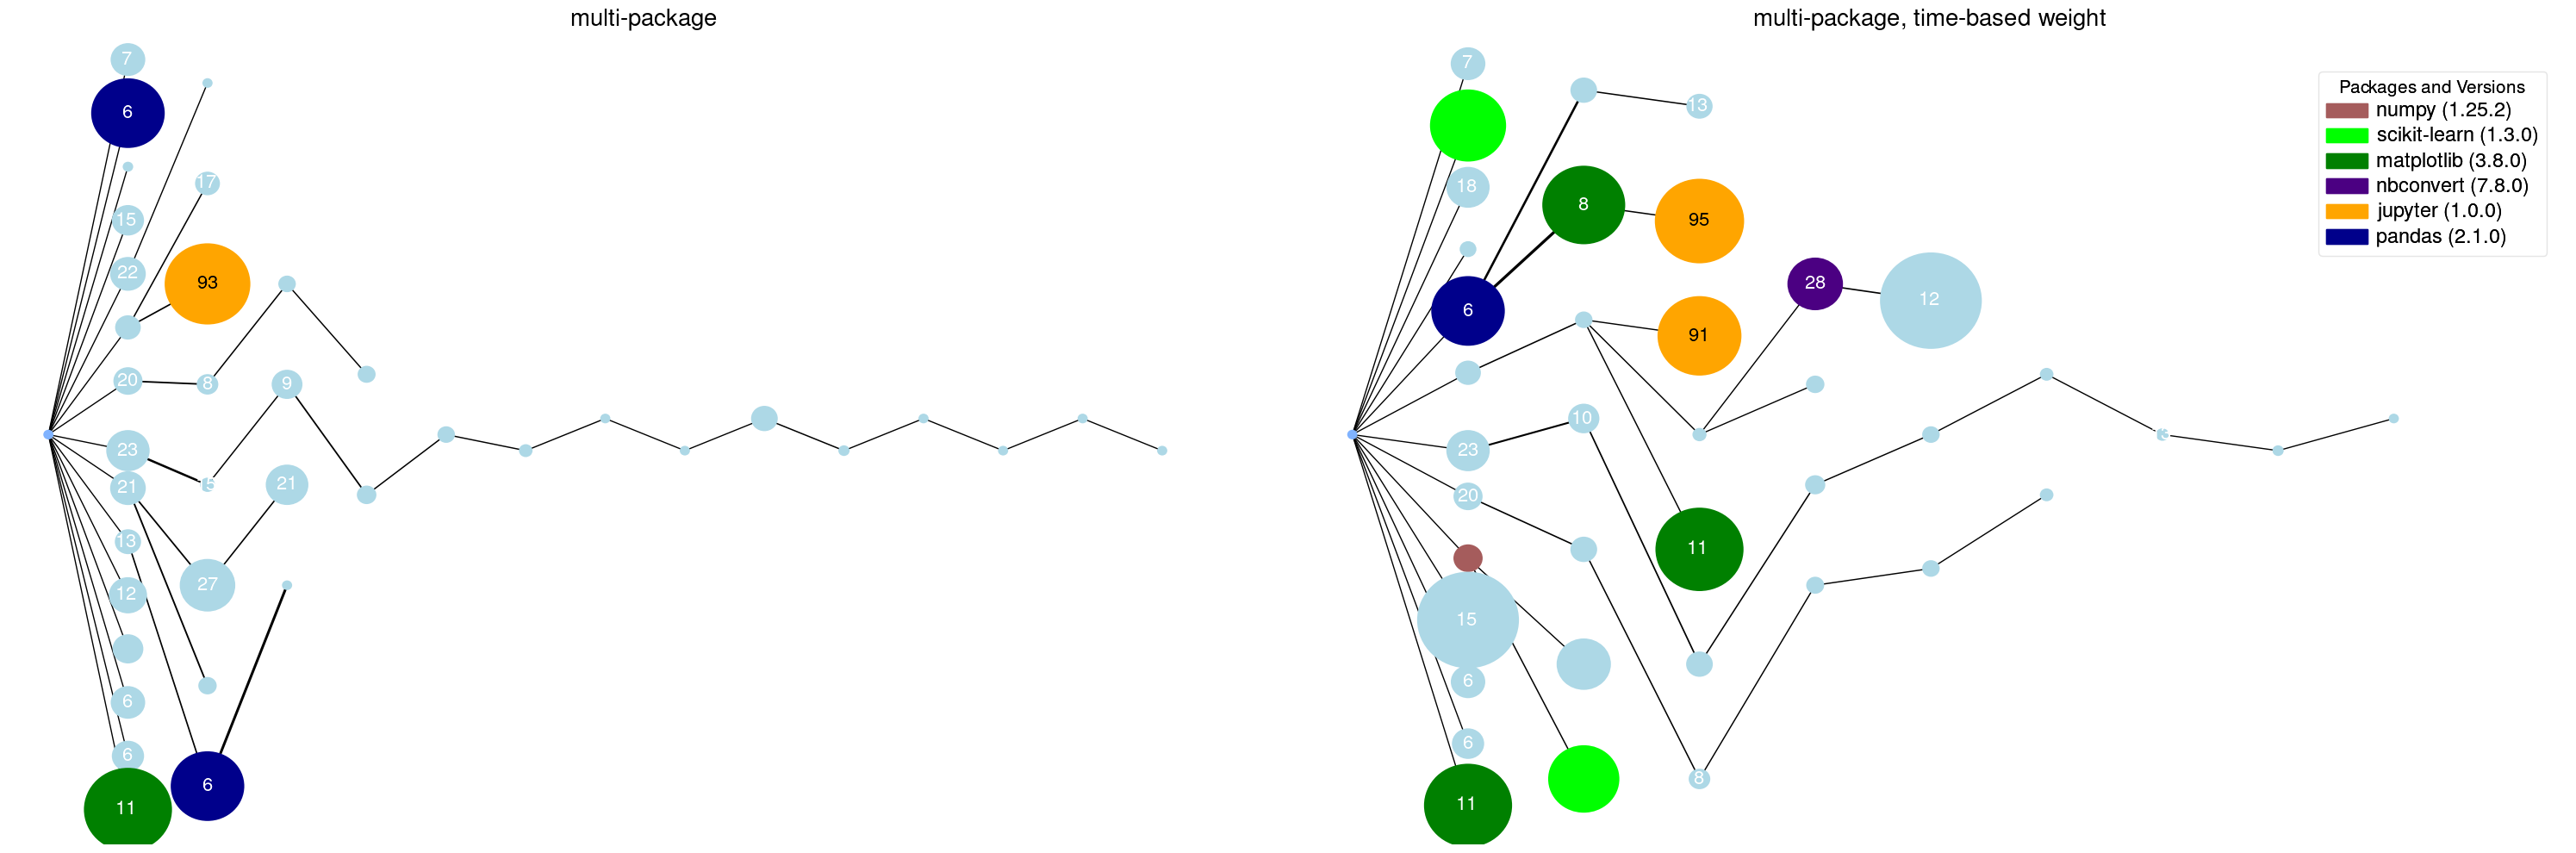

In [43]:
trees = [
os.path.join( "trials", "tree_gen", "1", "tree-v2.node-40.json"),
os.path.join( "trials", "tree_gen", "1", "tree-v3.node-40.json"),
]

titles = [
    "multi-package",
    "multi-package, time-based weight"
]
pkgs = {}
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
for i, tree_file in enumerate(trees):
    row_index = i // 2
    col_index = i % 2
    ax = axs[col_index]#ax = axs[row_index, col_index]

    ax = axs[i]
    _, sub_packages = draw_tree(tree_file, ax=ax, heat_color=False, legend=False)
    pkgs = merge_dicts(pkgs, sub_packages)
    ax.set_axis_off()
    if i<2:
        ax.set_title(titles[i], fontsize=20)
    
    ax.set_ylabel("dads") 

patches = []
labels = []
for package_name, versions in pkgs.items():
    for version in versions:
        color_hex = color_dict.get(package_name)
        color_rgb = get_color(package_name,version)
        patch = mpatches.Patch(color=color_rgb, label=f'{package_name} ({version})')
        patches.append(patch)
        labels.append(f'{package_name} ({version})')
patch = mpatches.Patch(color='lightblue', label='other')
patches.append(patch)

font_prop = FontProperties(family='Helvetica', size=17, weight='black')
legend = fig.legend(handles=patches, labels=labels, loc=(0.9, 0.70), title='Packages and Versions', 
                   title_fontsize=15, prop=font_prop,
                   handlelength=2, handletextpad=0.5, labelspacing=0.3)
frame = legend.get_frame()
frame.set_alpha(0.3)
legend.get_title().set_weight('black')
legend.get_title().set_fontname('Arial')
ax.add_artist(legend)

plt.tight_layout()

plt.savefig("v2_v3_120-node.pdf", format='pdf')
plt.show()

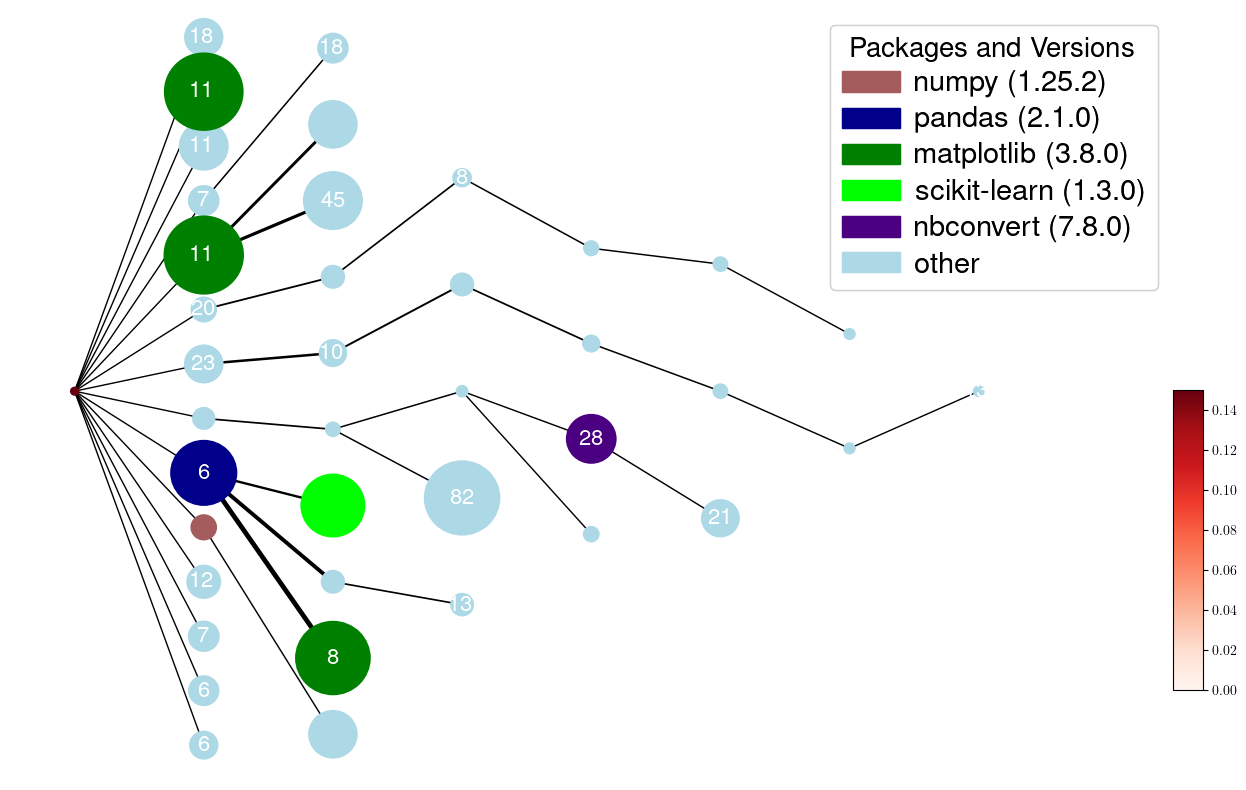

In [44]:
# tree_name="tree-v2.node-40"
ax,_ = draw_tree(os.path.join( "trials", "tree_gen", "3", tree_name+".json"), heat_color=True)

fig = ax.get_figure()
fig.savefig(os.path.join("pics", "0" , tree_name+".png"), bbox_inches='tight')

In [18]:
package_costs = json.load(open(os.path.join( 'costs.json')))

def statistics(tree):
    total_count = 0
    weighted_depth = 0
    non_root_count = 0
    weighted_package_cost = 0  

    def traverse_tree(node, depth=0):
        nonlocal total_count, weighted_depth, non_root_count, weighted_package_cost
        count = node.get('test_count', 0)
        total_count += count
        weighted_depth += count * depth
        if node.get('split_generation', 0) != 0:
            non_root_count += count

        node_package_cost_sum = sum(package_costs.get(package, {}).get('ms', 0) for package in node.get('packages', []))
        weighted_package_cost += node_package_cost_sum * count

        for child in node.get('children', []):
            traverse_tree(child, depth + 1)

    traverse_tree(tree)
    avg_depth = weighted_depth / total_count if total_count else 0
    non_root_ratio = non_root_count / total_count if total_count else 0
    avg_weighted_package_cost = weighted_package_cost / total_count if total_count else 0  

    return {
        'Average Depth (Weighted)': avg_depth,
        'Non-root hit Ratio': non_root_ratio,
        'Total Count': total_count,
        'Average Weighted Package Cost': avg_weighted_package_cost  
    }
tree_name="tree-v0.node-40"
tree_file_path = os.path.join( "trials", "tree_gen", "4", f"{tree_name}.json")
with open(tree_file_path, "r") as f:
    tree = json.load(f)
stats = statistics(tree)
print(stats)

{'Average Depth (Weighted)': 6.317820658342792, 'Non-root hit Ratio': 0.6220204313280363, 'Total Count': 881, 'Average Weighted Package Cost': 1.6047618987205756}


In [19]:
tree_name="tree-v1.node-40"
tree_file_path = os.path.join( "trials", "tree_gen", "4", f"{tree_name}.json")
with open(tree_file_path, "r") as f:
    tree = json.load(f)
stats = statistics(tree)
print(stats)

{'Average Depth (Weighted)': 3.3609534619750283, 'Non-root hit Ratio': 0.7128263337116912, 'Total Count': 881, 'Average Weighted Package Cost': 9.453128604694069}


In [20]:
tree_name="tree-v2.node-40"
tree_file_path = os.path.join( "trials", "tree_gen", "0", f"{tree_name}.json")
with open(tree_file_path, "r") as f:
    tree = json.load(f)
stats = statistics(tree)
print(stats)

{'Average Depth (Weighted)': 2.3064699205448354, 'Non-root hit Ratio': 0.6424517593643587, 'Total Count': 881, 'Average Weighted Package Cost': 28.926721631330476}


In [21]:
# the animation seems to be invalid
def animate_tree(path):
    ax = draw_tree(path)

    def update_func(frame_num):
        draw_tree(path, ax=ax, generation_max=frame_num)

    return HTML(animation.FuncAnimation(ax.get_figure(), update_func, frames=100, interval=250).to_html5_video())

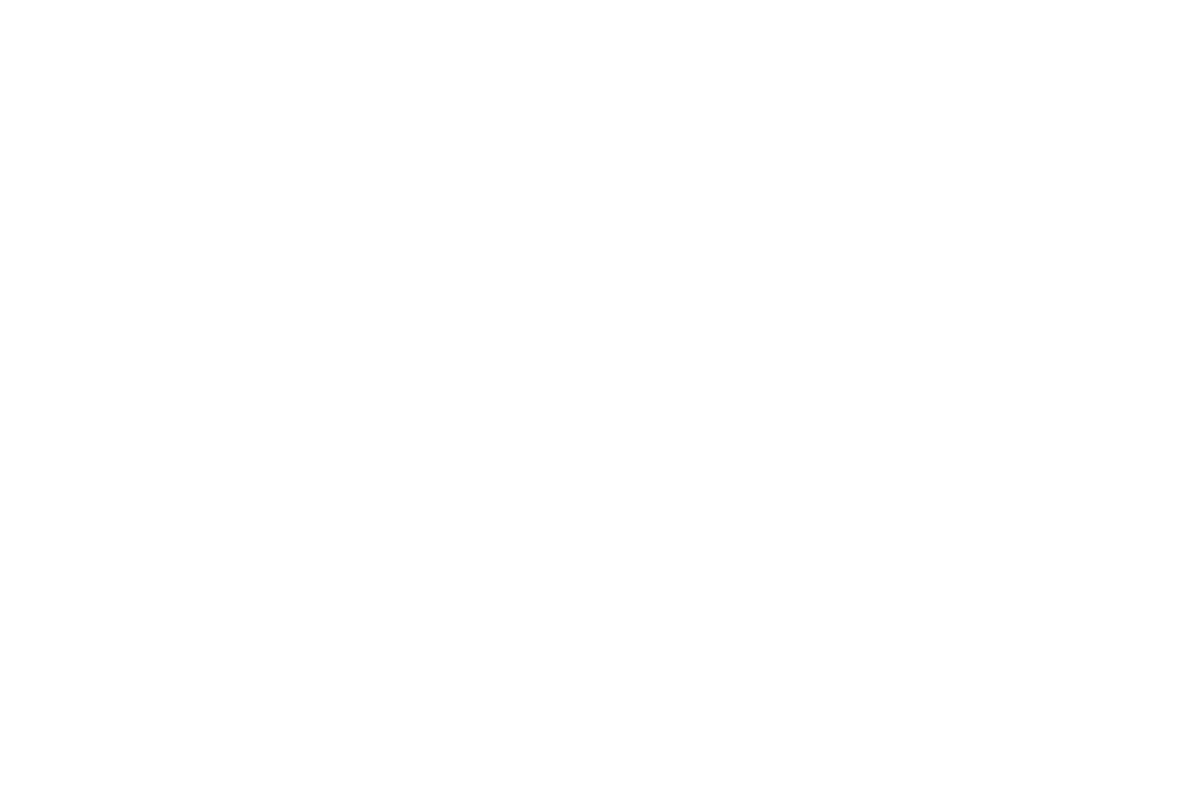

In [32]:
tree_name="tree-v0.node-40"
tree_file_path = os.path.join("trials", "tree_gen", "0", f"{tree_name}.json")
animate_tree(tree_file_path)

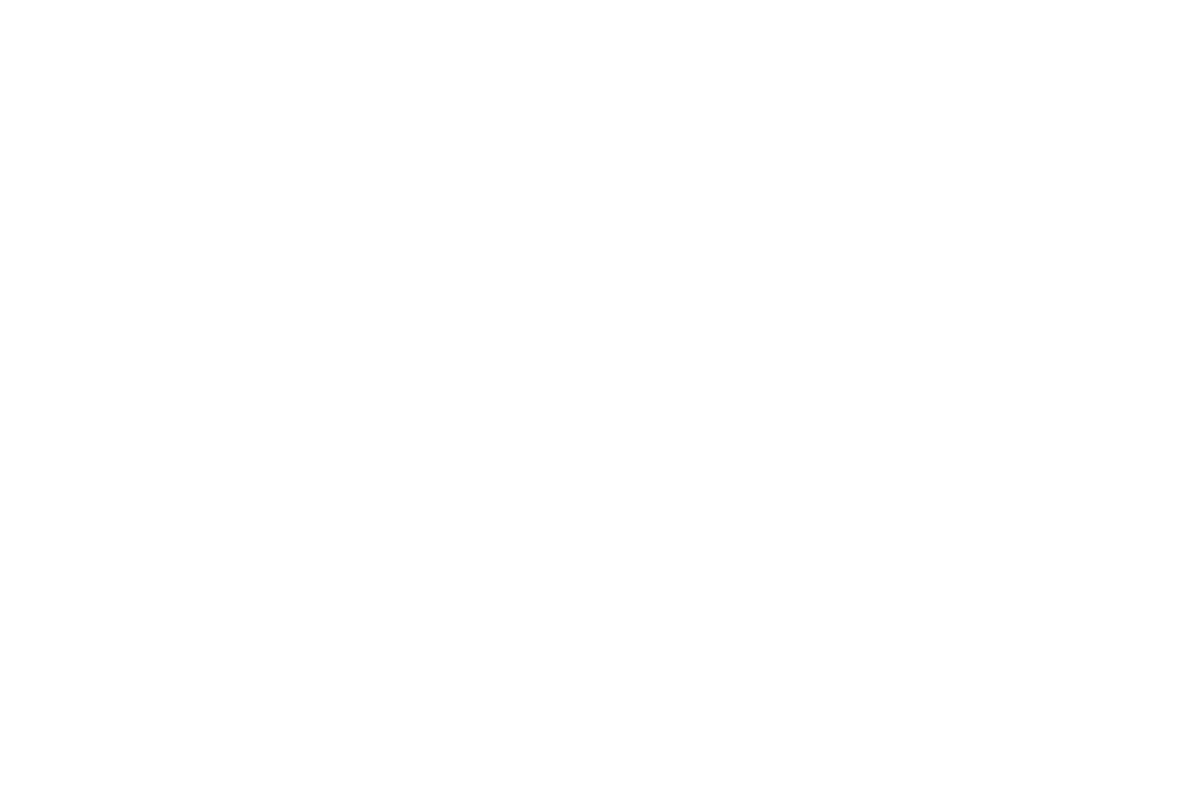

In [33]:
tree_name="tree-v1.node-40"
tree_file_path = os.path.join("trials", "tree_gen", "0", f"{tree_name}.json")
animate_tree(tree_file_path)